In [1]:
##
## UNet 
##
## Взята идея по описанию из https://github.com/pietz/unet-keras
##
##
## 2017-07-28
##   Добавлены flip+rotation LB=760393
##
## 2017-07-29
##   LB=769123 += 3000
##
## 2017-07-31
##   Level-1, KFold = 5, xloss, only flip
##   Покoпытим этот вариант, пока других идей нет
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.13.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model, load_model, Input, Model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, UpSampling2D, ZeroPadding2D
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense, Permute
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.6'

In [7]:
#---------------------------------------------------------------------

In [8]:
!ls -la ..
#!ls -la ../Data
#!ls -la ../Data/training

total 37
drwxrwxrwx 1 boba boba 4096 авг 16 18:37 .
drwxrwxrwx 1 boba boba    0 июл 25 09:21 ..
-rwxrwxrwx 1 boba boba 3217 авг 16 18:21 CODE_OF_CONDUCT.md
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 Data
drwxrwxrwx 1 boba boba    0 июл 25 09:22 Data-Arch
drwxrwxrwx 1 boba boba    0 авг 10 23:12 Data-Keras
drwxrwxrwx 1 boba boba 4096 авг 16 21:06 .git
-rwxrwxrwx 1 boba boba  146 авг 15 20:35 .gitignore
drwxrwxrwx 1 boba boba    0 июл 26 10:11 .ipynb_checkpoints
drwxrwxrwx 1 boba boba    0 авг 16 21:01 Jupyter
drwxrwxrwx 1 boba boba 4096 авг 16 21:00 Jupyter-Net
-rwxrwxrwx 1 boba boba 1211 авг 16 18:21 LICENSE
drwxrwxrwx 1 boba boba    0 авг 16 18:59 Python
-rwxrwxrwx 1 boba boba 2646 авг 16 18:21 README.md
drwxrwxrwx 1 boba boba 4096 авг  4 17:52 Result
drwxrwxrwx 1 boba boba 4096 авг  5 19:08 Temp
drwxrwxrwx 1 boba boba    0 июл 27 07:53 Work


In [9]:
dirData = '../Data'
dirTemp = '../Temp'
dirWork = '../Work'

dirTest  = os.path.join(dirData,'testing','images')
dirTrain = os.path.join(dirData,'training','images')
dirMask  = os.path.join(dirData,'training','truth')

In [10]:
listTrain = os.listdir(dirTrain)
listMask  = os.listdir(dirMask)
listTest  = os.listdir(dirTest)
listTrain = [xx for xx in listTrain if os.path.splitext(xx)[1]=='.tif']
listMask  = [xx for xx in listMask  if os.path.splitext(xx)[1]=='.png']
listTest  = [xx for xx in listTest  if os.path.splitext(xx)[1]=='.tif']
print(len(listTrain),len(listMask),len(listTest))
print(listTrain[:5],'\n',listMask[:5],'\n',listTest[:5])

168 168 162
['i105404.tif', 'i117557.tif', 'i124017.tif', 'i130790.tif', 'i137857.tif'] 
 ['i105404_mask.png', 'i117557_mask.png', 'i124017_mask.png', 'i130790_mask.png', 'i137857_mask.png'] 
 ['i105047.tif', 'i116596.tif', 'i137649.tif', 'i140176.tif', 'i142099.tif']


In [11]:
if 0 :
    for xx in listTrain[:5] :
        img = cv.imread(os.path.join(dirTrain,xx),-1)
        xxm = os.path.splitext(xx)[0]+"_mask.png"
        msk = cv.imread(os.path.join(dirMask,xxm),-1)
        plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(msk,'gray'); plt.show()
    plt.close()

In [12]:
#msk.shape, img.shape, img.min(), img.max(), msk.max(), #img[6:10,6:10], msk[6:10,6:10]

In [13]:
flagGray = False
Gauss    = 5
Median   = 5
if flagGray :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,1)), np.zeros((512,512,1))
else :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,3)), np.zeros((512,512,1))

for xx in listTrain :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(Gauss,Gauss),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],Median);
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trX0[6:506,6:506,0] = img[:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
    else :
        trX0[6:506,6:506,:] = img[:,:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
        trY0[trY0>=0.5] = 1.0
    trX.append(trX0.copy())
    trY.append(trY0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trX = np.array(trX)
trY = np.array(trY)

# аугментация
trXX, trYY, trXXX,trYYY = trX.copy(), trY.copy(), np.zeros((1)), np.zeros((1))


if 1 :
    # flipping
    for f in range(-1,2) :
        trXXX, trYYY = trX.copy(), trY.copy()
        for p in range(trXXX.shape[0]) :
            trXXX[p], trYYY[p,:,:,0] = cv.flip(trXXX[p],f), cv.flip(trYYY[p,:,:,0],f)
        trXX = np.vstack([trXX,trXXX])
        trYY = np.vstack([trYY,trYYY])
        print('flip :',f,trXX.shape,trYY.shape)

if 0 :
    # rotate +-90

    # rotate +90
    trXXX, trYYY = trX.copy(), trY.copy()
    for p in range(trX.shape[0]) :
        for i in range(trX.shape[1]) :
            for j in range(trX.shape[2]) :
                trXXX[p,i,j,:] = trX[p,j,trX.shape[1]-i-1]
                trYYY[p,i,j,:] = trY[p,j,trY.shape[1]-i-1]
    trXX = np.vstack([trXX,trXXX])
    trYY = np.vstack([trYY,trYYY])
    print('rotate +90:',trXX.shape,trYY.shape)

    # rotate -90
    trXXX, trYYY = trX.copy(), trY.copy()
    for p in range(trX.shape[0]) :
        for i in range(trX.shape[1]) :
            for j in range(trX.shape[2]) :
                trXXX[p,i,j,:] = trX[p,trX.shape[2]-j-1,i]
                trYYY[p,i,j,:] = trY[p,trY.shape[2]-j-1,i]
    trXX = np.vstack([trXX,trXXX])
    trYY = np.vstack([trYY,trYYY])
    print('rotate -90:',trXX.shape,trYY.shape)
    
trX, trY = trXX.copy(), trYY.copy()
del trXX,trYY
del trXXX,trYYY

# Считаем среднее по каналам и вычитаем из изображений
meanX = (trX[:,6:-6,6:-6,:].mean(axis=(1,2))).mean(axis=0)
stdX  = (trX[:,6:-6,6:-6,:].mean(axis=(1,2))).std(axis=0)
for cc in range(meanX.shape[0]) : 
    trX[:,6:-6,6:-6,cc] -= meanX[cc]    
print("mean={} std={}".format(meanX,stdX))
    
trX.shape, trX.min(), trX.max(), trY.shape, trY.min(), trY.max()
#[trY[xx].mean() for xx in range(10)]

flip : -1 (336, 512, 512, 3) (336, 512, 512, 1)
flip : 0 (504, 512, 512, 3) (504, 512, 512, 1)
flip : 1 (672, 512, 512, 3) (672, 512, 512, 1)
mean=[ 0.6473997   0.48950165  0.70839568] std=[ 0.06249822  0.09179847  0.08778627]


((672, 512, 512, 3),
 -0.62212117329585626,
 0.48696893986925865,
 (672, 512, 512, 1),
 0.0,
 1.0)

In [14]:
for xx in range(0) :
    img = trX[xx]
    xxm = trY[xx]
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(xxm[:,:,0],'gray'); plt.show()
plt.close()

In [15]:
#
# model UNET
#
#    https://github.com/pietz/unet-keras
#
#

def level_block(m, dim, depth, acti, dropout=0.25, batch=True):
    if depth > 0:
        
        x = m
        if batch : x = BatchNormalization()(x)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(x) #(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        m = MaxPooling2D((2, 2))(n)
        if dropout : m = Dropout(dropout)(m) ## add
        m = level_block(m, 2*dim, depth-1, acti, dropout=dropout, batch=batch)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same', kernel_initializer='he_normal')(m)
        ### 2017-08-01  !!!!!!!!!!! if dropout : m = Dropout(dropout)(m) ## add
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=2, dim=32, depth=5, acti='relu', flatten=False, dropout=0.25, batch=True):
    i = Input(shape=img_shape)
    ## ???? i = ZeroPadding2D((6,6),data_format="channels_last")
    o = level_block(i, dim, depth, acti, dropout=dropout, batch=batch)
    o = Conv2D(n_out, (1, 1), name='prediction',activation='sigmoid')(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    #o = Activation('relu')(o)
    ####if batch : o = BatchNormalization()(o)  ######
    ###o = Activation('sigmoid')(o)
    ###########if dropout : o = Dropout(dropout)(o) ## add 2017-08-01
    return Model(inputs=i, outputs=o)


In [16]:
model10 = UNet((512,512,3),depth=4+1,n_out=1, dropout=0.05, batch=False)
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 256, 256, 32)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [17]:
#
# 2017-07-31
#   Перестроил реализацию на метод ZFTurbo : +1.0 к знаменателю и числителю. Более корректно работает на пустых картинках.
#   На пустых картинках возможно зависание (==0, nan для x=0,  g = 0, s <> 0 (10-200))
#
#   Не очень понятно как это работает на всем batch, но на одном с batch_size=1 должно работать корректно
#
#
def dicePP (truth, pred, th=None) :
    
    g, s = K.sum(truth), K.sum(pred)
    x    = K.sum(truth*pred)
    return(K.clip((2.0*x+1.0)/(g+s+1.0), K.epsilon(), 1.0))
    #return((1.0 if K.sum(g+s)==0.0 else 2.0*x/(g+s+K.epsilon())))
    
import tensorflow as tf
def dice01 (truth, pred_, th=0.5) :
    
    #thPred = K.greater(pred_,th)
    
    pred   = tf.to_float(K.greater(pred_,th))
    
    g, s = K.sum(truth), K.sum(pred)
    x    = K.sum(truth*pred)
    return (K.clip((2.0*x+1.0)/(g+s+1.0),K.epsilon(),1.0))
    
def dicePP01 (truth, pred, th=0.5) : return((dice01(truth,pred,th=th)+dicePP(truth,pred,th=th))/2.0)

def dice (truth, pred, th=0.5) : 
    return(dice01(truth,pred,th=th))
#    return((dice01(truth,pred,th=th)+dicePP(truth,pred,th=th))/2.0)

def diceNP01 (truth,pred_, th=0.5, printOK=False) :
    pred = pred_.copy()
    pred[pred>th]  = 1.0
    pred[pred<=th] = 0.0
    g, s = truth.sum(), pred.sum()
    x    = (truth*pred).sum()
    if printOK : print('x={} g={} s={}'.format(x,g,s))
    return((2.0*x+1.0)/(g+s+1.0))
    #return((1.0 if K.sum(g+s)==0.0 else 2.0*x/(g+s+K.epsilon())))

def diceNPPP (truth,pred, th=0.5, printOK=False) :
    g, s = truth.sum(), pred.sum()
    x    = (truth*pred).sum()
    if printOK : print('x={} g={} s={}'.format(x,g,s))
    return((2.0*x+1.0)/(g+s+1.0))
    #return((1.0 if K.sum(g+s)==0.0 else 2.0*x/(g+s+K.epsilon())))

def diceNP (truth,pred, printOK=False) :
    return(diceNP01(truth,pred))
#    return(diceNPPP(truth,pred))
#    return((diceNPPP(truth,pred)+diceNP01(truth,pred))/2.0)

def f1 (truth,pred) :
    TP = K.sum(truth*pred)
    TN = K.sum((1.0-truth)*(1.0-pred))
    FP = K.sum(truth*(1.0-pred))
    FN = K.sum((1.0-truth)*pred)

    
    P  = 1.0 if K.sum(TP+FP)==0.0 else TP/(TP+FP)
    R  = 0.0 if K.sum(TP+FN)==0.0 else TP/(TP+FN) 

    F1 = 0.0 if K.sum(P+R)  ==0.0 else 2.0*P*R/(P+R)

    return(F1)

def lossdice (truth,pred) :
    return(1.0 - dice(truth,pred))

import keras.losses as losses

def lossXdice (truth,pred) :
    return(losses.binary_crossentropy(truth,pred) - K.log(dicePP01(truth,pred)))

def lossYdice (truth,pred) :
    return( - K.log(dicePP01(truth,pred) ))

In [18]:
def modelBuild (input_shape) :
    model = UNet(input_shape,depth=5-1+1,n_out=1,dropout=0.07,batch=False)
    return(model)
    
def modelCompile (model, lr=0.01) :
    sgd     = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
    adam    = keras.optimizers.adam(lr=lr)
    nadam   = keras.optimizers.nadam(lr=lr)
    rmsprop = keras.optimizers.rmsprop(lr=lr)
    adamax  = keras.optimizers.adamax(lr=lr)
    adagrad = keras.optimizers.adagrad(lr=lr)
    #model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
    model.compile(loss=lossXdice, # 'binary_crossentropy', #'mean_absolute_error',  #'binary_crossentropy',
                  optimizer=sgd, #nadam, #sgd, #"adam", #'rmsprop',
                  metrics=[dice,'binary_accuracy']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)


def buildModel (input_shape, lr=0.01) :
    model = modelBuild(input_shape)
    model = modelCompile(model, lr=lr)
    return(model)

In [19]:
K.clear_session()
#model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
model10 = modelBuild((trX.shape[1],trX.shape[2],trX.shape[3]))
model10 = modelCompile(model10)

model10.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 256, 256, 32)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [20]:
#model10.load_weights('../Data-Keras/Models/model-UNet-weights.h5', by_name=False)
batch_size = 1

In [22]:
#foldN      = trX.shape[0]/folds+1; 
#foldN, foldN*4, trX.shape[0], len(tFold), len(vFold)

In [27]:
epochs     =  150
#epochs     = 50
verbose    = 2
batch_size = 1
metric     = 'binary_accuracy'
metric     = 'dice'
initial    = 0

############trX, trY = trX[0:30], trY[0:30]

folds        = 3 #5
foldN      = trX.shape[0]/folds+1

print(datetime.datetime.now(),'Training with folds')

##for i in range(folds) :
for i in [0,1,2] : #[1,2] : #range(1,3) :

    initial    = 0
    print(datetime.datetime.now(),'------------>',i)

    K.clear_session()
    model10 = modelBuild((trX.shape[1],trX.shape[2],trX.shape[3]))
    ############if 1 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7660-2.hdf5')
    model10 = modelCompile(model10,lr=0.0001)
    flag = 0
    if os.path.exists('../Temp/NewStep/PostAnalyze/V1-UNET-X-DICE01-NADAM2---'+str(i)+'.hdf5') : 
        model10.load_weights('../Temp/NewStep/PostAnalyze/V1-UNET-X-DICE01-NADAM2---'+str(i)+'.hdf5')
        initial    = 50
        print('OK Load=','../Temp/NewStep/PostAnalyze/V1-UNET-X-DICE01-NADAM2---'+str(i)+'.hdf5')
    flag = 0

    early_stopping = EarlyStopping(monitor='loss', patience=15,min_delta=0.0001,verbose=1)
#    early_stopping = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.0001,verbose=1)
#    early_stopping = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.0001,verbose=1)
    reduce_lr1     = ReduceLROnPlateau(monitor='loss',     factor=0.5, patience=8, min_lr=0.0000001,verbose=1)
    reduce_lr2     = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=0.0000001,verbose=1)

    filepath="../Temp/NewStep/PostAnalyze/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}-e={epoch}-X-DICE01-NADAM2---"+str(i)+".hdf5"
    #filepath="../Temp/NewStep/StandartF5/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
    #filepath="../Temp/TempTempG5M5KFold10/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

    tFold = [True]*(i*foldN)+[False]*foldN+[True]*trX.shape[0];
    tFold = tFold[:trX.shape[0]]
    
    tFold  = np.array(tFold)
    trYsum = trY.sum(axis=(1,2,3))/(trY.shape[1]*trY.shape[2]*trY.shape[3])
    tFold [trYsum>=0.90] = True
    tFold [trYsum<=0.05] = True
    
    vFold = np.logical_not(tFold)

    if 0 :
        import random
        random.seed(999)
        np.random.seed(999)
        bba = []
        for ii in range(10) :
            print(datetime.datetime.now(),ii,'--------->')
            b_tr, b_te, notnot = [], [], [] #[5,33,47,111]
            for bb in range(trX.shape[0]) :
                if bb not in notnot :
                    te = model10.test_on_batch(trX[bb:bb+1],trY[bb:bb+1])
                    b_te.append(te)
                    if te[0]>=1.4 : print(bb,'test',te)
            for bb in range(trX.shape[0]) :
                if bb not in notnot :
                    tr = model10.train_on_batch(trX[bb:bb+1],trY[bb:bb+1])
                    b_tr.append(tr)
                    if tr[0]>=1.4 : print(bb,'train',tr)
            bba.append((ii,b_tr,b_te))
        break
        
    #hist1  = model10.fit(trX[low:high],trY[low:high],
    hist  = model10.fit(trX[tFold],trY[tFold],
                        epochs=epochs, batch_size=batch_size, 
                        #validation_split=0.20, 
                        validation_data=(trX[vFold],trY[vFold]),
                        initial_epoch = initial,
                        #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                        #callbacks=[reduce_lr1,reduce_lr2,checkpoint1,checkpoint2,early_stopping],
                        callbacks=[reduce_lr1,checkpoint2,early_stopping], #,reduce_lr2],
                        verbose=verbose)
    
    import pickle
    opt = hist.history
    pickle.dump( opt, open( "../Data-Keras/Optimizer/NF-"+str(i), "wb" ) )

    

print(datetime.datetime.now())

2017-08-16 21:29:59.408347 Training with folds
2017-08-16 21:29:59.409663 ------------> 0
OK= ../Temp/NewStep/PostAnalyze/V1-UNET-X-DICE01-NADAM2---0.hdf5
Train on 471 samples, validate on 201 samples
Epoch 51/51
Epoch 00050: val_dice improved from -inf to 0.76664, saving model to ../Temp/NewStep/PostAnalyze/V1-UNET-val_dice=0.7666-0.7606-e=50-X-DICE01-NADAM2---0.hdf5
239s - loss: 0.6350 - dice: 0.7606 - binary_accuracy: 0.8990 - val_loss: 0.6600 - val_dice: 0.7666 - val_binary_accuracy: 0.8639
2017-08-16 21:34:01.009991 ------------> 1
OK= ../Temp/NewStep/PostAnalyze/V1-UNET-X-DICE01-NADAM2---1.hdf5
Train on 473 samples, validate on 199 samples
Epoch 51/51
Epoch 00050: val_dice improved from -inf to 0.78024, saving model to ../Temp/NewStep/PostAnalyze/V1-UNET-val_dice=0.7802-0.7584-e=50-X-DICE01-NADAM2---1.hdf5
245s - loss: 0.6465 - dice: 0.7584 - binary_accuracy: 0.8958 - val_loss: 0.5990 - val_dice: 0.7802 - val_binary_accuracy: 0.8816
2017-08-16 21:38:30.386145 ------------> 2
OK= 

In [29]:
if 0 :
    import pickle
    #opt = histNF.history
    #pickle.dump( opt, open( "../Data-Keras/Optimizer/NF-"+str(i), "wb" ) )
    opt = pickle.load(open( "../Data-Keras/Optimizer/NF-"+str(i), "rb" ))

    opt



In [148]:
model10.optimizer.get_config()

{'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'epsilon': 1e-08,
 'lr': 9.999999747378752e-05,
 'schedule_decay': 0.004}

In [174]:
trYsum = trY.sum(axis=(1,2,3))/(trY.shape[1]*trY.shape[2]*trY.shape[3])
trYsum[trYsum>=0.9].shape

(5,)

In [192]:
bba = []
for ii in range(1) :
    print(datetime.datetime.now(),ii,'--------->')
    b_tr, b_te, notnot = [], [], [] #[5,33,47,111]
    for bb in range(trX.shape[0]) :
        if bb not in notnot :
            te = model10.test_on_batch(trX[bb:bb+1],trY[bb:bb+1])
            b_te.append(te)
            if te[0]>=1.4 : print(bb,'test',te)
    for bb in range(0) : #(trX.shape[0]) :
        if bb not in notnot :
            tr = model10.train_on_batch(trX[bb:bb+1],trY[bb:bb+1])
            b_tr.append(tr)
            if tr[0]>=1.4 : print(bb,'train',tr)
    b_tr = b_te
    bba.append((ii,b_tr,b_te))

2017-08-08 22:37:07.114955 0 --------->
43 test [1.414619, 0.74839914, 0.74494934]
47 test [1.5813537, 0.65374589, 0.8656311]


In [123]:
#bba
#xx = [loss for loss,dice,ba in bba[0][1]]; xx

0.280328 0.878127


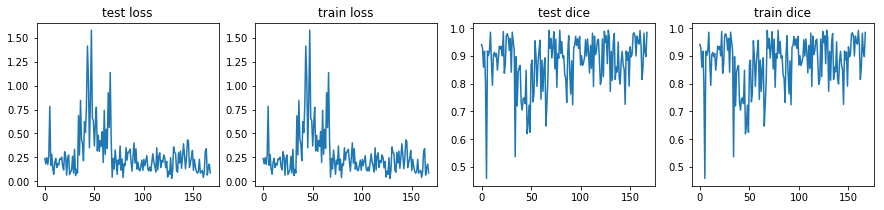

In [193]:
for i in range(0,len(bba)) :
    print(np.array([loss  for loss,dices,bac in bba[i][1]]).mean(),np.array([dices  for loss,dices,bac in bba[i][1]]).mean())
    plt.figure(figsize=(15,3))
    plt.subplot(142); plt.plot(np.array([loss  for loss,dices,bac in bba[i][1]])); plt.title('train loss')
    plt.subplot(141); plt.plot(np.array([loss  for loss,dices,bac in bba[i][2]])); plt.title('test loss')
    plt.subplot(144); plt.plot(np.array([dices for loss,dices,bac in bba[i][1]])); plt.title('train dice')
    plt.subplot(143); plt.plot(np.array([dices for loss,dices,bac in bba[i][2]])); plt.title('test dice')
    #print(np.array([xx[1] for _,xx,_ in bba[i]]).mean())
    plt.show(); 
plt.close()

In [211]:
if 0 :
    import pickle
    opt = pickle.load(open( "../Data-Keras/Optimizer/optimizers", "rb" ))
    opt['sgdDice'] = histSGDN.history
    pickle.dump( opt, open( "../Data-Keras/Optimizer/optimizers", "wb" ) )
    if 0 :
        opt = {}
        opt['adam-4']   = histAdam.history
        opt['nadam-4']  = histNadam.history
        opt['rmsprop-4']= histRMSProp.history
        opt['adamax-4'] = histADAMax.history
        opt['adagrad-4']= histADAgrad.history
        opt['sgd-3']    = histSGD.history
        pickle.dump( opt, open( "../Data-Keras/Optimizer/optimizers", "wb" ) )
        #pickle.dump( histAdam.history, open( "../Data-Keras/Optimizer/adam", "wb" ) )
        #pickle.dump( histNadam.history, open( "../Data-Keras/Optimizer/nadam", "wb" ) )
        #pickle.dump( histRMSProp.history, open( "../Data-Keras/Optimizer/rmsprop", "wb" ) )
        #pickle.dump( histADAMax.history, open( "../Data-Keras/Optimizer/adamax", "wb" ) )
        #pickle.dump( histADAgrad.history, open( "../Data-Keras/Optimizer/adagrad", "wb" ) )
        #pickle.dump( histAdam.history, open( "../Data-Keras/Optimizer/adam", "wb" ) )

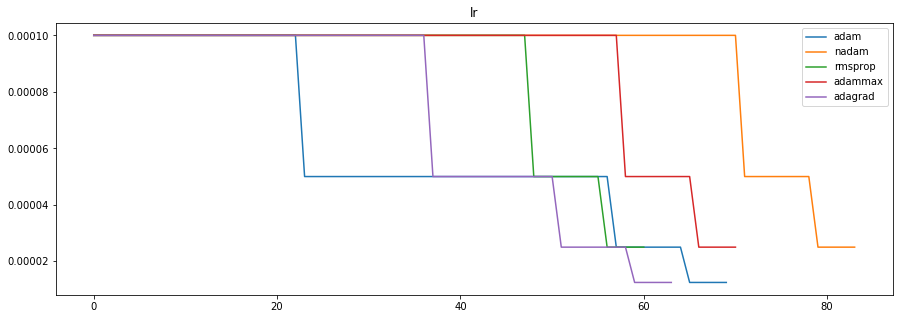

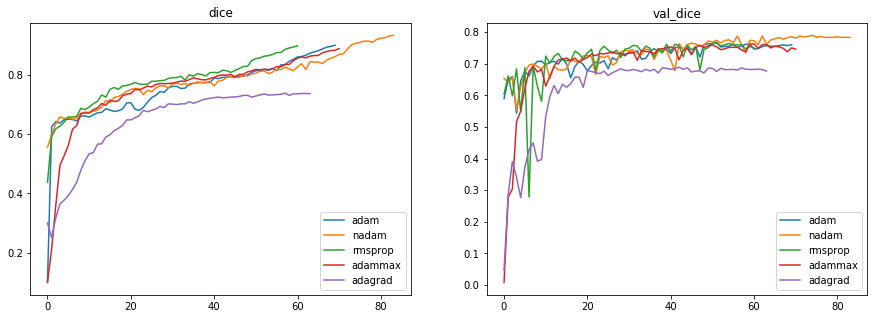

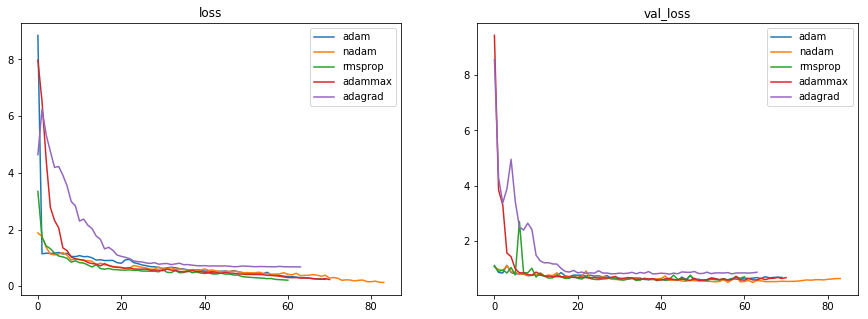

In [80]:
plt.figure(figsize=(15,5))
#plt.subplot(131)
name='lr'
plt.plot(np.array(histAdam.history[name]));
plt.plot(np.array(histNadam.history[name]));
plt.plot(np.array(histRMSProp.history[name]));
plt.plot(np.array(histADAMax.history[name]));
plt.plot(np.array(histADAgrad.history[name]));
plt.title(name)
plt.legend(['adam','nadam','rmsprop','adammax','adagrad'])
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(121)
name='dice'
plt.plot(np.array(histAdam.history[name]));
plt.plot(np.array(histNadam.history[name]));
plt.plot(np.array(histRMSProp.history[name]));
plt.plot(np.array(histADAMax.history[name]));
plt.plot(np.array(histADAgrad.history[name]));
plt.title(name)
plt.legend(['adam','nadam','rmsprop','adammax','adagrad'])
plt.subplot(122)
name='val_dice'
plt.plot(np.array(histAdam.history[name]));
plt.plot(np.array(histNadam.history[name]));
plt.plot(np.array(histRMSProp.history[name]));
plt.plot(np.array(histADAMax.history[name]));
plt.plot(np.array(histADAgrad.history[name]));
plt.title(name)
plt.legend(['adam','nadam','rmsprop','adammax','adagrad'])
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(121)
name='loss'
plt.plot(np.array(histAdam.history[name]));
plt.plot(np.array(histNadam.history[name]));
plt.plot(np.array(histRMSProp.history[name]));
plt.plot(np.array(histADAMax.history[name]));
plt.plot(np.array(histADAgrad.history[name]));
plt.title(name)
plt.legend(['adam','nadam','rmsprop','adammax','adagrad'])
plt.subplot(122)
name='val_loss'
plt.plot(np.array(histAdam.history[name]));
plt.plot(np.array(histNadam.history[name]));
plt.plot(np.array(histRMSProp.history[name]));
plt.plot(np.array(histADAMax.history[name]));
plt.plot(np.array(histADAgrad.history[name]));
plt.title(name)
plt.legend(['adam','nadam','rmsprop','adammax','adagrad'])
plt.show()
plt.close()

In [25]:
#!ls ../Temp/TempTempG5M5KFold -la | tail
#!ls ../Temp/TempTempG5M5KFold10 -la | tail
#!ls ../Temp/NewStep/StandartF3 -la | tail
#!ls ../Temp/NewStep/Level-1-loss -la | tail
!ls ../Temp/NewStep/PostAnalyze -la -tr| grep 'NADAM2---0' | tail

-rwxrwxrwx 1 boba boba 248911048 авг  9 14:30 V1-UNET-val_dice=0.8629-0.8354-e=60--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 14:47 V1-UNET-val_dice=0.8637-0.8375-e=64--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 15:27 V1-UNET-val_dice=0.8644-0.8403-e=73--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 15:57 V1-UNET-val_dice=0.8647-0.8419-e=80--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 16:59 V1-UNET-val_dice=0.8650-0.8467-e=94--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 17:38 V1-UNET-val_dice=0.8652-0.8482-e=103--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 17:42 V1-UNET-val_dice=0.8657-0.8490-e=104--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 18:13 V1-UNET-val_dice=0.8669-0.8493-e=111--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 авг  9 20:11 V1-UNET-val_dice=0.8671-0.8558-e=138--X--DICE-NADAM2---0.hdf5
-rwxrwxrwx 1 boba boba 248911048 

In [26]:
if 0 : model10 = load_model('../Temp/TrainModel001+G+M/V1-UNET-0.8511.hdf5')
if 0 : model10 = load_model('../Temp/V1-UNET-0.8853.hdf5')
#if 1 : model10 = load_model('../Temp/TempTempM3/V1-UNET-0.9054.hdf5')
if 0 : model10.load_weights('../Temp/TempTempM3/V1-UNET-0.9054.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5/V1-UNET-val_dice=0.7307.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold/V1-UNET-val_dice=0.7879-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7632-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7660-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7828-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold5/V1-UNET-val_dice=0.8224-0.8516---1.hdf5') # 769128
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold5/V1-UNET-val_dice=0.8217-0.8655---1.hdf5') # 765XXX
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold5/V1-UNET-val_dice=0.8227-0.8643---3.hdf5')    
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold10/V1-UNET-val_dice=0.8315-0.8617---9.hdf5')    
if 0 : model10.load_weights('../Temp/NewStep/StandartF3/V1-UNET-val_dice=0.7655-0.7360---2.hdf5')    
if 0 : model10.load_weights('../Temp/NewStep/Level-1/V1-UNET-val_dice=0.7561-0.7261---2.hdf5')    
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.8063-0.8532---0.hdf5') # 767XXX
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.8183-0.8691---1.hdf5') # 770XXX
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.7695-0.7984-Z3BCE-D02G0M0-0.hdf5') # 755959 test=872197
#---------------------------------------

if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.7630-0.7971-e=65--X--D10G5M5---1.hdf5') #
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.7661-0.8130-e=80--X--D10G5M5---2.hdf5') # 763517 test=899919
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.7541-0.7690-e=111--X--D10G5M5---3.hdf5') #
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.7568-0.7567-e=40--X--D10G5M5---0.hdf5') #
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.7264-0.7443-e=82--X--D10G5M5---3.hdf5') #
    
#---------------------------------------

if 1 : model10.load_weights('../Temp/NewStep/PostAnalyze/V1-UNET-val_dice=0.8675-0.8563-e=146--X--DICE-NADAM2---0.hdf5') #





In [23]:
%time trP = model10.predict(trX,batch_size=batch_size)

CPU times: user 1min, sys: 14.9 s, total: 1min 15s
Wall time: 1min 13s


In [24]:
def thP01 (trP, th=0.5) :
    trP01 = trP.copy()
    trP01[trP>th] =1.0
    trP01[trP<=th]=0.0
    trP01 = trP01.astype(np.uint8)
    return(trP01)

def thP01OTSU (trP, ext=False) :
    trP01 = trP.copy()
    th_otsu = []
    for i in range(trP.shape[0]) :
        trP01X = (trP[i,:,:,0]*255.0).astype(np.uint8)
        ret,trP01X = cv.threshold(trP01X,0,1,cv.THRESH_BINARY+cv.THRESH_OTSU)
        trP01[i,:,:,0] = trP01X[:,:]
        th_otsu.append(ret); #print(thresh,ret)
        #plt.subplot(121); plt.imshow(trP[i,:,:,0]); plt.subplot(122); plt.imshow(trP[i,:,:,0]); plt.show()
        
    if not ext : return(trP01)    
    
    th_otsu = np.array(th_otsu).astype(np.int16)/255.0
    return(trP01,th_otsu)
    #plt.hist(th_otsu.ravel(),bins=50); plt.show()
    #plt.close()        
    #print('th-otsu mean={}, std={}'.format(th_otsu.mean(),th_otsu.std()))
    #print(np.array(th_otsu[:166]))    
    

In [25]:
trP01 = thP01(trP)

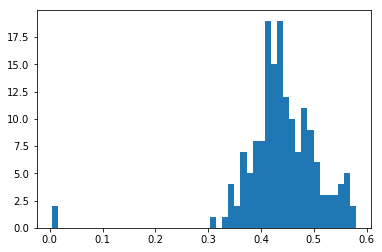

train th-otsu mean=0.439475549256, std=0.0732990460708


In [26]:
#
#
# 2017-07-31 otsu расчет для каждой картинки
#
#
otsu = 1
if otsu :
    trP01O, th_otsu = thP01OTSU(trP[:166],ext=True)
    plt.hist(th_otsu.ravel(),bins=50); plt.show()
    plt.close()        
    print('train th-otsu mean={}, std={}'.format(th_otsu.mean(),th_otsu.std()))
    #print(np.array(th_otsu[:166]))

In [28]:
if 0 : # Ощутимых результатов не дает, увеличение в +10-100
    times, medianP = 3,5
    for i in range(trP01.shape[0]) :
        for j in range(times) :
            trP01[i,:,:,0] = cv.medianBlur(trP01[i],medianP)

(512, 512, 3) (512, 512, 1) (672, 512, 512, 1) 6.72392e-05 0.99986


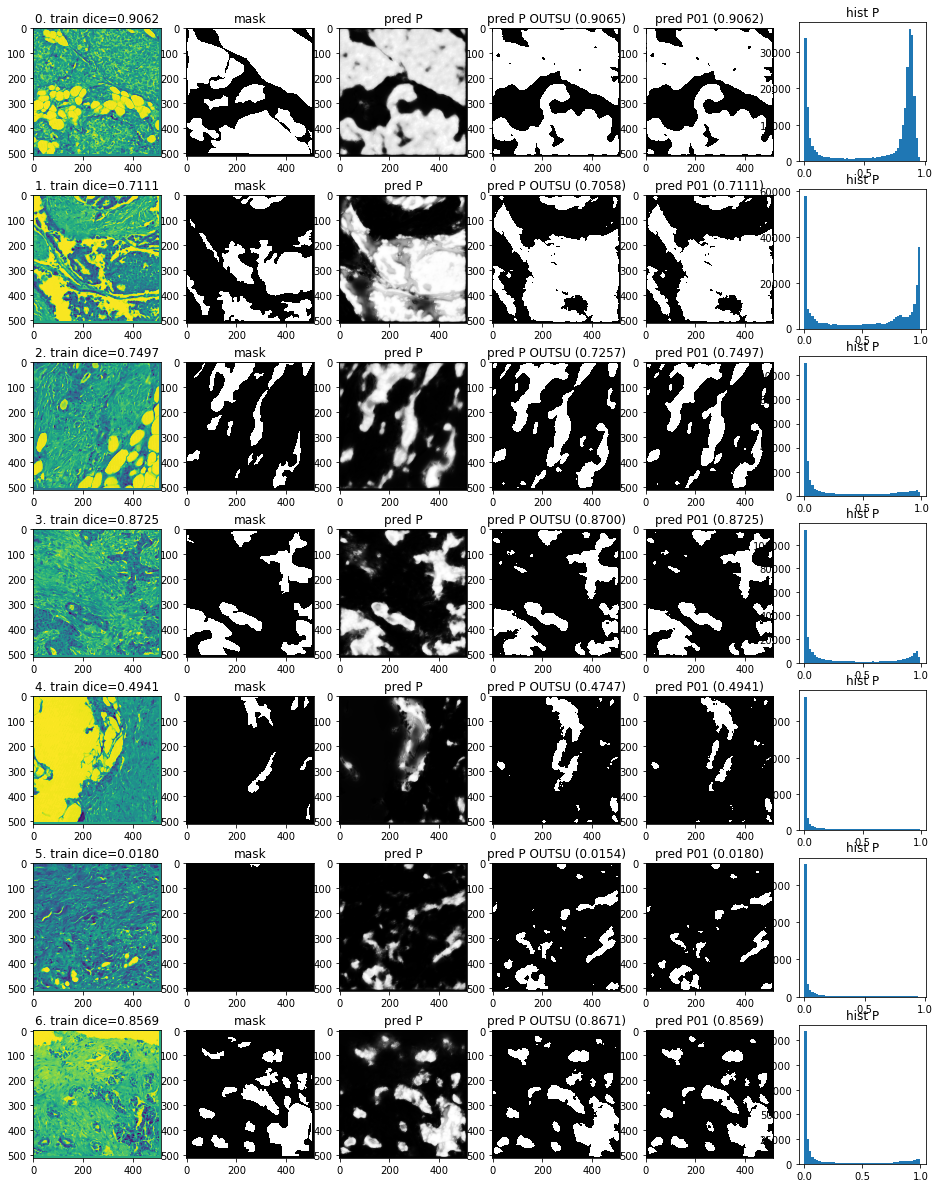

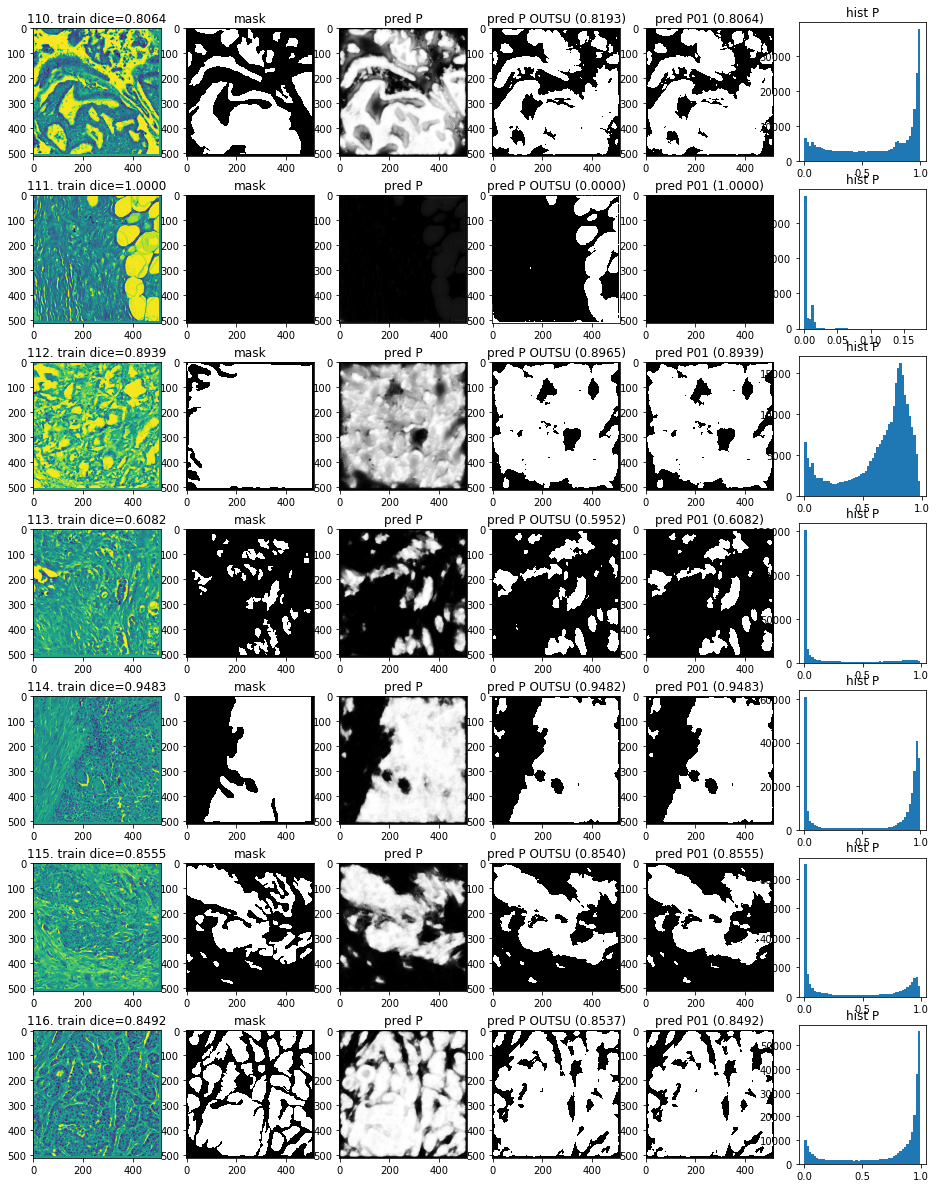

In [39]:
save = 0
iii,picts = 110, 7
print(trX[0].shape,trY[0].shape,trP.shape,trP.min(),trP.max())
plt.figure(figsize=(16,3*picts))
for ii in range(iii,iii+picts) :
    pdice = diceNP(trY[ii,:,:,0],trP01[ii,:,:,0])
    plt.subplot(picts,6,(ii-iii)*6+1); plt.imshow(trX[ii,:,:,0]); plt.title('{}. train dice={:.4f}'.format(ii,pdice))
    plt.subplot(picts,6,(ii-iii)*6+2); plt.imshow(trY[ii,:,:,0],'gray'); plt.title('mask')
    plt.subplot(picts,6,(ii-iii)*6+3); plt.imshow(trP[ii,:,:,0],'gray'); plt.title('pred P')
    plt.subplot(picts,6,(ii-iii)*6+5); plt.imshow(trP01[ii,:,:,0],'gray'); plt.title('pred P01'+' ({:.4f})'.format(pdice))
    if otsu : 
        pdice = diceNP(trY[ii,:,:,0],trP01O[ii,:,:,0])
        plt.subplot(picts,6,(ii-iii)*6+4); plt.imshow(trP01O[ii,:,:,0],'gray'); plt.title('pred P OUTSU'+' ({:.4f})'.format(pdice))
    plt.subplot(picts,6,(ii-iii)*6+6); plt.hist(trP[ii,:,:,0].ravel(),bins=50); plt.title('hist P')
    
if save : plt.savefig(os.path.join(dirs,'train-set+mask+pred+otsu.png'))
plt.show()
plt.close()

In [30]:
# Calculate F1-micro

In [31]:
TP = (trY[:,6:506,6:506,0]*trP01[:,6:506,6:506,0]).sum()
TN = ((1.0-trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FP = ((trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FN = ((1.0-trY[:,6:506,6:506,0])*(trP01[:,6:506,6:506,0])).sum()

P  = TP/(TP+FP) if (TP+FP)>0.0001 else 1.0
R  = TP/(TP+FN) if (TP+FN)>0.0001 else 0.0

F1 = 2.0*P*R/(P+R) if (P+R)>0.0001 else 0.0

TP,TN,FP,FN,P,R,F1
#P*R,P+R, 2.0*P*R/(P+R)

(50255909.0,
 99473791.0,
 6096971.0,
 12173329.0,
 0.89180728651312946,
 0.80500596531388069,
 0.84618644365307583)

In [32]:
# Calculate DI- dice.mean()

In [33]:
diceTrain = []
for i in range(166) : #trP.shape[0]) :
    diceTrain.append(diceNP(trY[i,6:-6,6:-6,0],trP01[i,6:-6,6:-6,0]))
di = (np.array(diceTrain)).mean()
di #,np.array(dice)  #,np.array(XX)

0.7693759546154969

In [35]:
if 1 :
    di_th = []
    for i in range(1,10) : 
        th = (0.0+i)/10.0
        trP01D = thP01(trP,th=th)
        diceTrainD = []
        for i in range(166) : #trP.shape[0]) :
            diceTrainD.append(diceNP(trY[i,6:-6,6:-6,0],trP01D[i,6:-6,6:-6,0]))
        diD = (np.array(diceTrainD)).mean()
        di_th.append((th,diD))
di_th

[(0.1, 0.70426522527874369),
 (0.2, 0.74097474520033779),
 (0.3, 0.7562668129661021),
 (0.4, 0.76482188049768074),
 (0.5, 0.7693759546154969),
 (0.6, 0.7694010295157967),
 (0.7, 0.76131242751450379),
 (0.8, 0.73335675984532367),
 (0.9, 0.60354329408703833)]

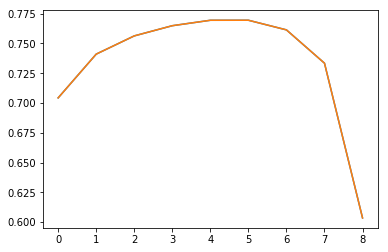

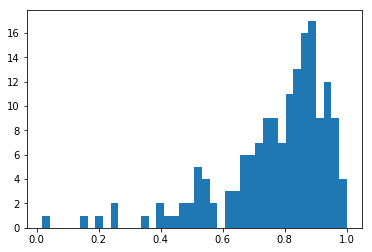

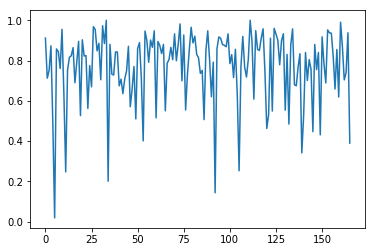

5

In [36]:
plt.plot(np.array([xx for th,xx in di_th])); plt.plot(np.array([xx for th,xx in di_th])); plt.show(); plt.close() 

plt.hist(np.array(diceTrain),bins=40); plt.show()
plt.plot(np.array(diceTrain)); plt.show()
np.array(diceTrain).argmin()

In [37]:
1000000*(F1+di)/2.0

807781.19913428638

In [38]:
#np.array(dice)<0.4

In [39]:
# Подготовка test решения

In [40]:
if flagGray :
    trO, trO0 = [], np.zeros((512,512,1))
else :
    trO, trO0 = [], np.zeros((512,512,3))

for xx in listTest :
    img = cv.imread(os.path.join(dirTest,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(Gauss,Gauss),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],Median);
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trO0[6:506,6:506,0] = img[:,:]/255.0
    else :
        trO0[6:506,6:506,:] = img[:,:,:]/255.0
    trO.append(trO0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trO = np.array(trO)

if 1 :
    for cc in range(meanX.shape[0]) : 
        trO[:,6:506,6:506,cc] -= meanX[cc]
    
trO.shape, trO.min(), trO.max()
#[trY[xx].mean() for xx in range(10)]

((162, 512, 512, 3), -0.6417290164331112, 0.47912580261435672)

In [41]:
%time trOP = model10.predict(trO,batch_size=batch_size)

CPU times: user 14.8 s, sys: 3.29 s, total: 18.1 s
Wall time: 17.4 s


In [42]:
trOP01 = thP01(trOP)

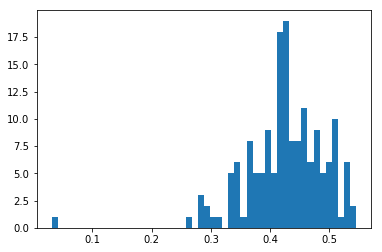

test th-otsu mean=0.425344952796, std=0.0672439145013


In [43]:
otsu = 1
if otsu :
    trOP01O, th_otsu = thP01OTSU(trOP,ext=True)
    plt.hist(th_otsu.ravel(),bins=50); plt.show()
    plt.close()        
    print('test th-otsu mean={}, std={}'.format(th_otsu.mean(),th_otsu.std()))
    #print(np.array(th_otsu[:166]))

(512, 512, 3) (512, 512, 1) (162, 512, 512, 1) 6.42588e-09 0.940998


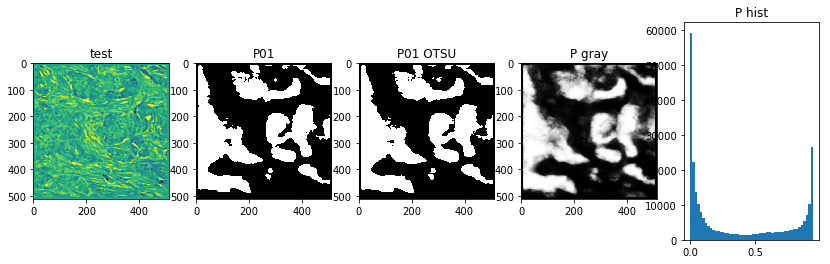

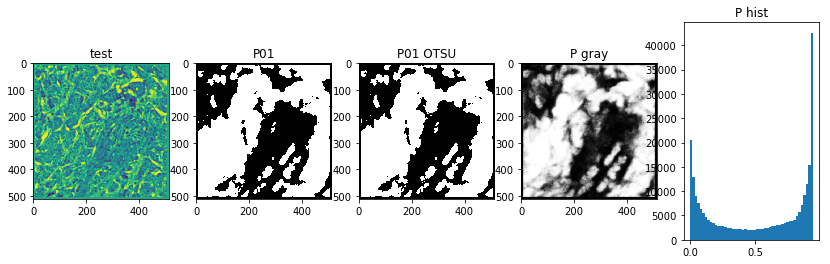

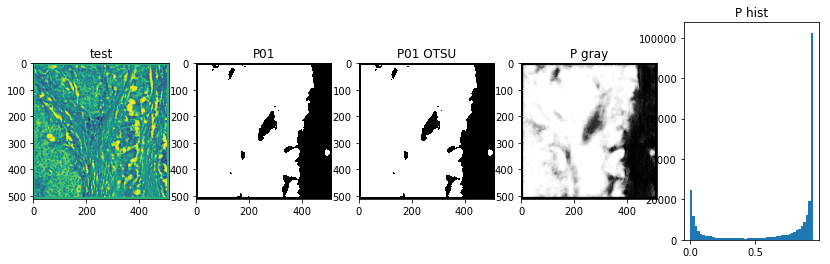

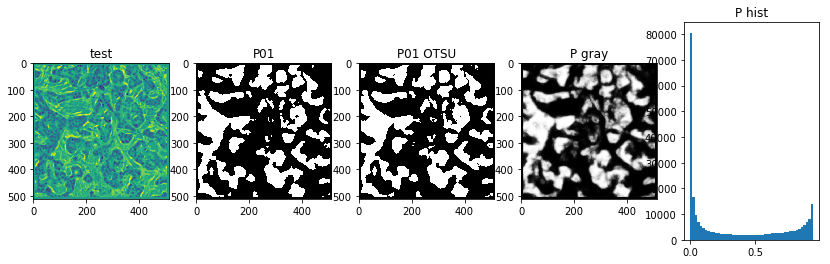

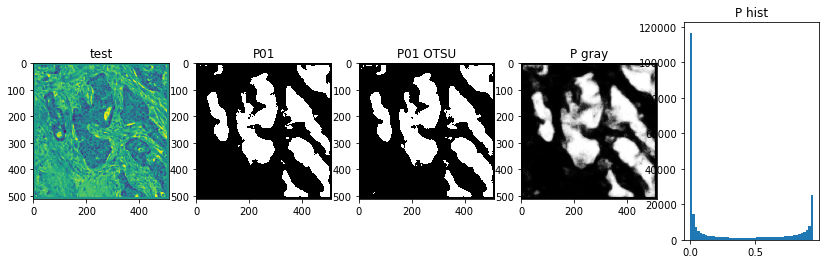

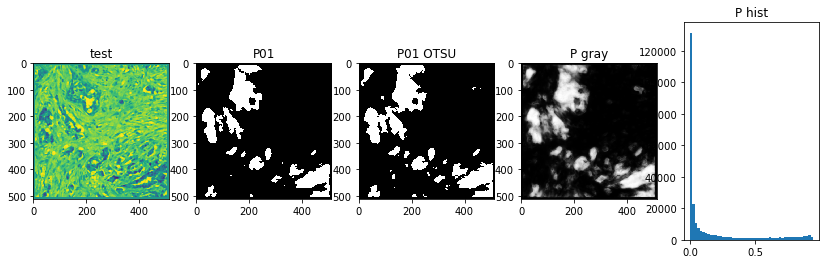

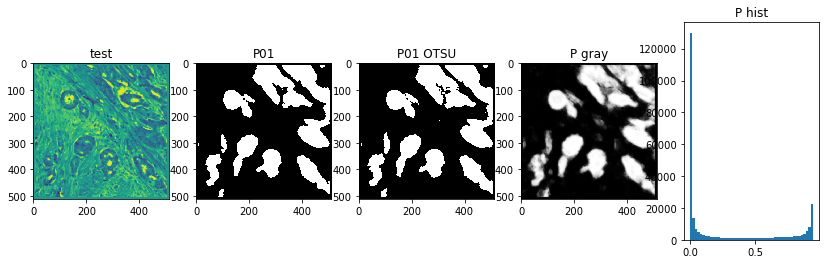

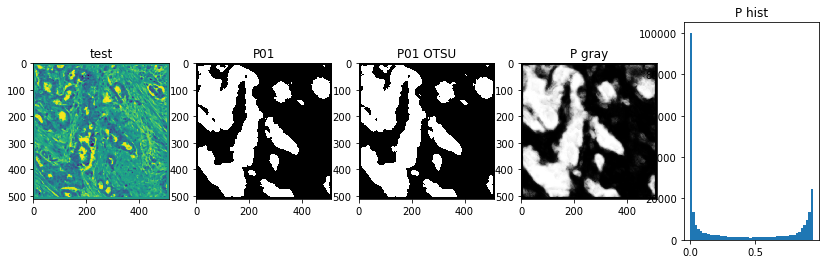

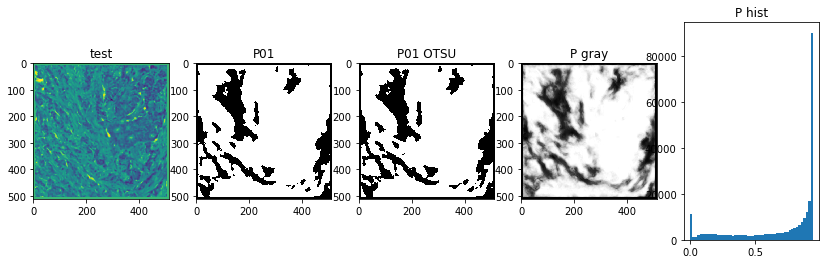

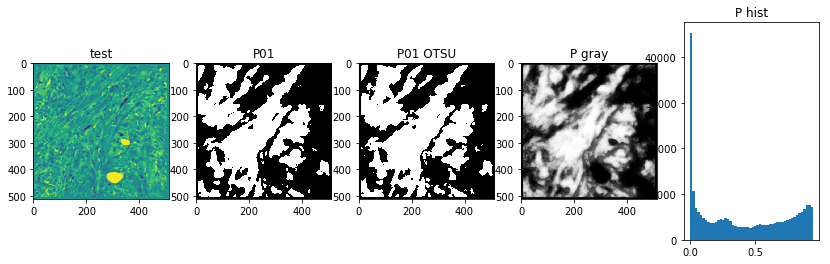

In [44]:
iii = 40
print(trO[0].shape,trP01[0].shape,trOP01.shape,trOP.min(),trOP.max())
for ii in range(iii,iii+10) :
    plt.figure(figsize=(17,4))
    plt.subplot(161); plt.imshow(trO[ii,:,:,0]); plt.title('test')
    plt.subplot(162); plt.imshow(trOP01 [ii,:,:,0],'gray'); plt.title('P01')
    if otsu : plt.subplot(163); plt.imshow(trOP01O[ii,:,:,0],'gray'); plt.title('P01 OTSU')
    plt.subplot(164); plt.imshow(trOP[ii,:,:,0],'gray');  plt.title('P gray')
    plt.subplot(165); plt.hist(trOP[ii,:,:,0].ravel(),bins=50);  plt.title('P hist')
    plt.show()
plt.close()

In [45]:
otsu = 0
if otsu : trOP01 = trOP01O; print(datetime.datetime.now(),'otsu datas')

In [44]:
# Формирование выходной директории

In [45]:
def convert_to_binary(truth_png_file, truth_txt_file):
    im = Image.open(truth_png_file) #Can be many different formats.
    pix = im.load()
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(pix[x, y] > 0)))
            out.write('\n')

if not os.path.exists('../Temp/random_submission'):
    os.makedirs('../Temp/random_submission')

# Training
for i in range(len(listTrain)) :
    fn = listTrain[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()
    
# Testing
for i in range(len(listTest)) :
    fn = listTest[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trOP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()

In [46]:
import shutil

In [47]:
xx=shutil.make_archive('../Result/topcoderkonica','zip','../Temp/random_submission')
xx

'/media/boba/DATA/boba/Working/TopCoder/2017-07-25-Konica-Minolta/Result/topcoderkonica.zip'

In [400]:
!ls ../Temp -la

total 4610508
drwxrwxrwx 1 boba boba      4096 июл 26 10:58 .
drwxrwxrwx 1 boba boba      4096 июл 26 10:11 ..
drwxrwxrwx 1 boba boba         0 июл 25 18:17 .ipynb_checkpoints
drwxrwxrwx 1 boba boba     61440 июл 26 09:14 random_submission
-rwxrwxrwx 1 boba boba   1057596 июл 26 10:58 random_submission.zip
drwxrwxrwx 1 boba boba         0 июл 25 23:35 TrainModel001-G-M
drwxrwxrwx 1 boba boba         0 июл 25 22:21 TrainModel001-G+M
drwxrwxrwx 1 boba boba         0 июл 25 21:48 TrainModel001+G-M
drwxrwxrwx 1 boba boba      4096 июл 25 21:05 TrainModel001+G+M
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:02 V1-UNET-0.8167.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:08 V1-UNET-0.8275.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:33 V1-UNET-0.8305.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:02 V1-UNET-0.8418.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8486.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8593.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 

In [389]:
!ls ../Work -la
#!ls ../Temp/random_submission

total 80768
drwxrwxrwx 1 boba boba        0 июл 26 09:17 .
drwxrwxrwx 1 boba boba     4096 июл 25 15:24 ..
-rwxrwxrwx 1 boba boba 82700662 июл 26 09:32 topcoderkonica.zip


In [36]:
if False :
    save_model(model10,'../Data-Keras/Models/model-UNet.h5')
    model10.save_weights('../Data-Keras/Models/model-UNet-weights.h5')

In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
